# Triangle diagram
In this notebook, I calculate a triangle diagram for an arbitrary case
Internal masses are noted $m_i$, $i=1,2,3$, The symmetric external masses are noted by $M_i$, $i=1,2,3$.

The fuction ```triangle_disp(A1,m2sq,m3sq,M1sq,M2sq,M3sq)``` calculates amplitude for the triangle graph, shown in the figure below.
![Triangle diagram to introduce notations](pict/triangle.png)

### Details
The calculations are done in the 
$$
A = \int \frac{\mathrm{d} s'}{s'-s} \frac{1}{\lambda(s',M_2^2,M_3^2)}
\int_{t_-(s')}^{t_+(s')} \mathrm{d}t\, t_1(t,s')
$$
Some detais:
 * Integrals to $\inf$ are performed with $\tan(\theta)$-map
 * The angular projection integral is done differently in two regions:
  - below $s_\text{flip}$ point: $t_-$ is connected to $t_+$ through $(t_-+t_+)/2+i$
  - above $s_\text{flip}$ piont: the point connected through the threshold.
  - function $t_1(t)$ is supposed to have no LHC

In [29]:
# Pkg.add("QuadGK")

In [30]:
using QuadGK

In [78]:
function ChewMandelstam(x,m1sq,m2sq)
    m1 = sqrt(m1sq); m2 = sqrt(m2sq)
    #
    first_log_terms = 
        -1/x*sqrt((m1 + m2)^2 - x)*sqrt((m1 - m2)^2 - x) *
            log(
                (sqrt((m1+m2)^2 - x) +  sqrt((m1-m2)^2 - x)) /
                    (2.0*sqrt(m1*m2))
            ) +
        (m1sq - m2sq)/(4*x)*log(m1sq/m2sq)
    #
    last_term = (m1 == m2) ? 1/m2sq : (log(m1sq) - log(m2sq))/(m1sq - m2sq)
    #
    res = first_log_terms - (m1sq + m2sq)/4.0*last_term - 0.5
    return (-2.0)/π*res
end

ChewMandelstam (generic function with 1 method)

In [33]:
using Plots

INFO: Recompiling stale cache file /localhome/mikhasenko/.julia/lib/v0.6/Plots.ji for module Plots.


In [114]:
const CMKs = ChewMandelstam(0.892^2+0.0im,0.496^2,0.14^2);
function tKsq(s)
    mKsq = 0.496^2;
    mπsq = 0.14^2;
    λ(x,y,z) = x^2+y^2+z^2-2x*y-2y*z-2z*x
    mKs = 0.892;
    ΓKs = 0.05;
    mKs*ΓKs/(mKs^2-s-mKs*ΓKs*(ChewMandelstam(s+0.0im,mπsq,mKsq)-real(CMKs))/imag(CMKs))
end

tKsq (generic function with 1 method)

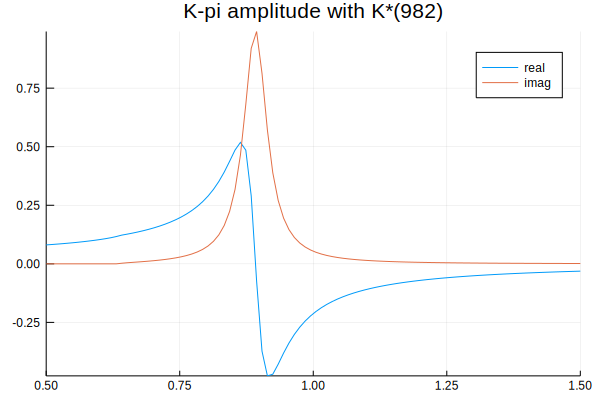

In [324]:
ev = linspace(0.5,1.5,100);
cal = [tKsq(e^2) for e in ev];
plot(ev,real(cal), lab="real")
plot!(ev,imag(cal), lab="imag",title = "K-pi amplitude with K*(982)")

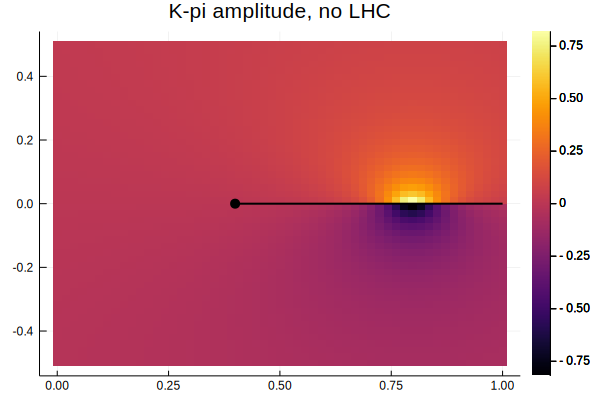

In [323]:
sxv = linspace(0,1.0,55)
syv = linspace(-0.5,0.5,50)
cal = [tKsq(sx+1.0im*sy) for sy in syv, sx in sxv];
heatmap(sxv, syv, imag(cal))
plot!(title = "K-pi amplitude, no LHC")
let th = (0.14+0.492)^2
    plot!([th, 1.0], [0.0, 0.0], lw=2, lc=:black, lab="")
    plot!([th], [0.0], m=:circle, ms =5, mc=:black,lab="")
end
plot!()

In [202]:
using Cuba

In [316]:
function triangle_disp(tsc1,m2sq,m3sq,M1sq,M2sq,M3sq)
    λ(x,y,z) = x^2+y^2+z^2-2x*y-2y*z-2z*x
    # integral in the complex plane
    function chain(f,t,intervals...)
        it = floor(t*(length(intervals)-1))+1
        t0 = (it-1)/(length(intervals)-1)
    #     @show it, t0
        p = intervals[it] +
            (intervals[it+1]-intervals[it])*(t-t0)*(length(intervals)-1)
        return f(p)*(intervals[it+1]-intervals[it])*(length(intervals)-1)
    end

    m2 = sqrt(m2sq); m3 = sqrt(m3sq); th = (m2+m3)^2
    M2 = sqrt(M2sq); M3 = sqrt(M3sq)
    # other thresholds in s-channel
    pth23 = (sqrt(M3sq)-sqrt(M2sq))^2
    th23 = (sqrt(M3sq)+sqrt(M2sq))^2
    # thresholds in t-channel
    tht = (sqrt(M2sq)+m3)^2
    
    function integrand(x, f)
        θ = x[2]*π/2.0; sp = th+tan(θ)
        
        tlims = M3sq+m2sq-(sp+M3sq-M2sq)*(sp+m2sq-m3sq)/(2sp) +
            sqrt((M2+M3)^2-sp-1e-6im) *
            sqrt((M2-M3)^2-sp-1e-6im) *
            sqrt(λ(sp+0.0im,m2sq,m3sq))/(2sp)*[-1.0, 1.0]
        p1 = tlims[1] # minus sign
        p2 = tlims[2] #  plus sign
        # turning points
        sflip = M3sq + m2sq - (th+M3sq-M2sq)/sqrt(th/m2sq)

        t = x[1]; integr = 0.0+0.0im
        if sp ≤ th
            # leave it zero
        elseif sp < sflip
            integr = chain(tsc1,t,p1,(p2+p1)/2.0+1.0im,p2) # tsc1
        elseif sp < pth23
            integr = chain(tsc1,t,p1,tht-1.0im,tht+1.0im,p2) # tsc1
        elseif sp < th23
            integr = chain(tsc1,t,p1,tht-1.0im,tht+1.0im,p2) # tsc1
        elseif sp ≥ th23
            integr = chain(tsc1,t,p1,tht-1.0im,tht+1.0im,p2) # tsc1
        end
        res = integr/(sp-M1sq-1e-4im)/(
            sqrt((M2+M3)^2-sp-1e-6im) *
            sqrt((M2-M3)^2-sp-1e-6im)
            )/cos(θ)^2
        res *= π/2.0
        f[1],f[2] = reim(res)
    end
    inn = cuhre(integrand,2,2)[1]::Array{Float64,1}
    return (complex(inn...))::Complex{Float64}
#     f = [0.0,0.0]
#     @code_warntype integrand([0.1,0.1],f)
end

triangle_disp (generic function with 1 method)

In [317]:
@time triangle_disp(tKsq,0.496^2,0.496^2,1.1^2,0.14^2,1.42^2)

  1.291500 seconds (10.28 M allocations: 518.623 MiB, 10.13% gc time)


-0.011332901609859926 + 0.23346585918780063im

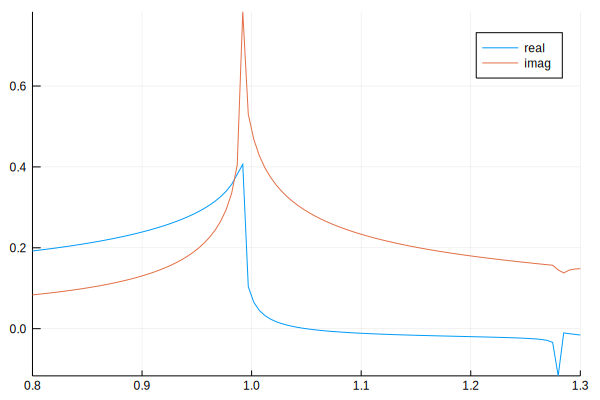

In [318]:
ev = linspace(0.8,1.3,100)
cal = [triangle_disp(tKsq,0.496^2,0.496^2,e^2,0.14^2,1.42^2) for e in ev];
plot(ev,real(cal), lab="real")
plot!(ev,imag(cal), lab="imag")

A spike at 1.28 in an artifact of the numerical integration.